In [1]:
import glob
import importlib
import os
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import prettypyplot as pplt
import seaborn as sns
from matplotlib import ticker

import extq
import ivac

In [2]:
sys.path.insert(1, "/project/dinner/scguo/ci-vsd/python/")
import plotting
import util

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div)

# Load data

In [4]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
ivac_trajs = np.load(
    f"{DATA_DIR}/raw_feat/ivac_less_feat_10-1000.npy", allow_pickle=True
)
ivac_models = np.load(f"{DATA_DIR}/models_ivac_less_feat_10-1000.npy")
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns lag time
# weights
weights = np.load(
    f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[
    0
]  # 0.1 ns lag time

In [5]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [6]:
mask = ~(down_ids | up_ids)
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)

In [7]:
from extq.stop import forward_stop

In [8]:
# compute E[\theta(x) S_tq_+(x)]
tic1 = [t[:-lag, 1] for t in ivac_trajs]
tic2 = [t[:-lag, 2] for t in ivac_trajs]
w_delay = [w[:-lag] for w in weights]
qp_delay = []
for d, t in zip(in_domain, qp_du):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

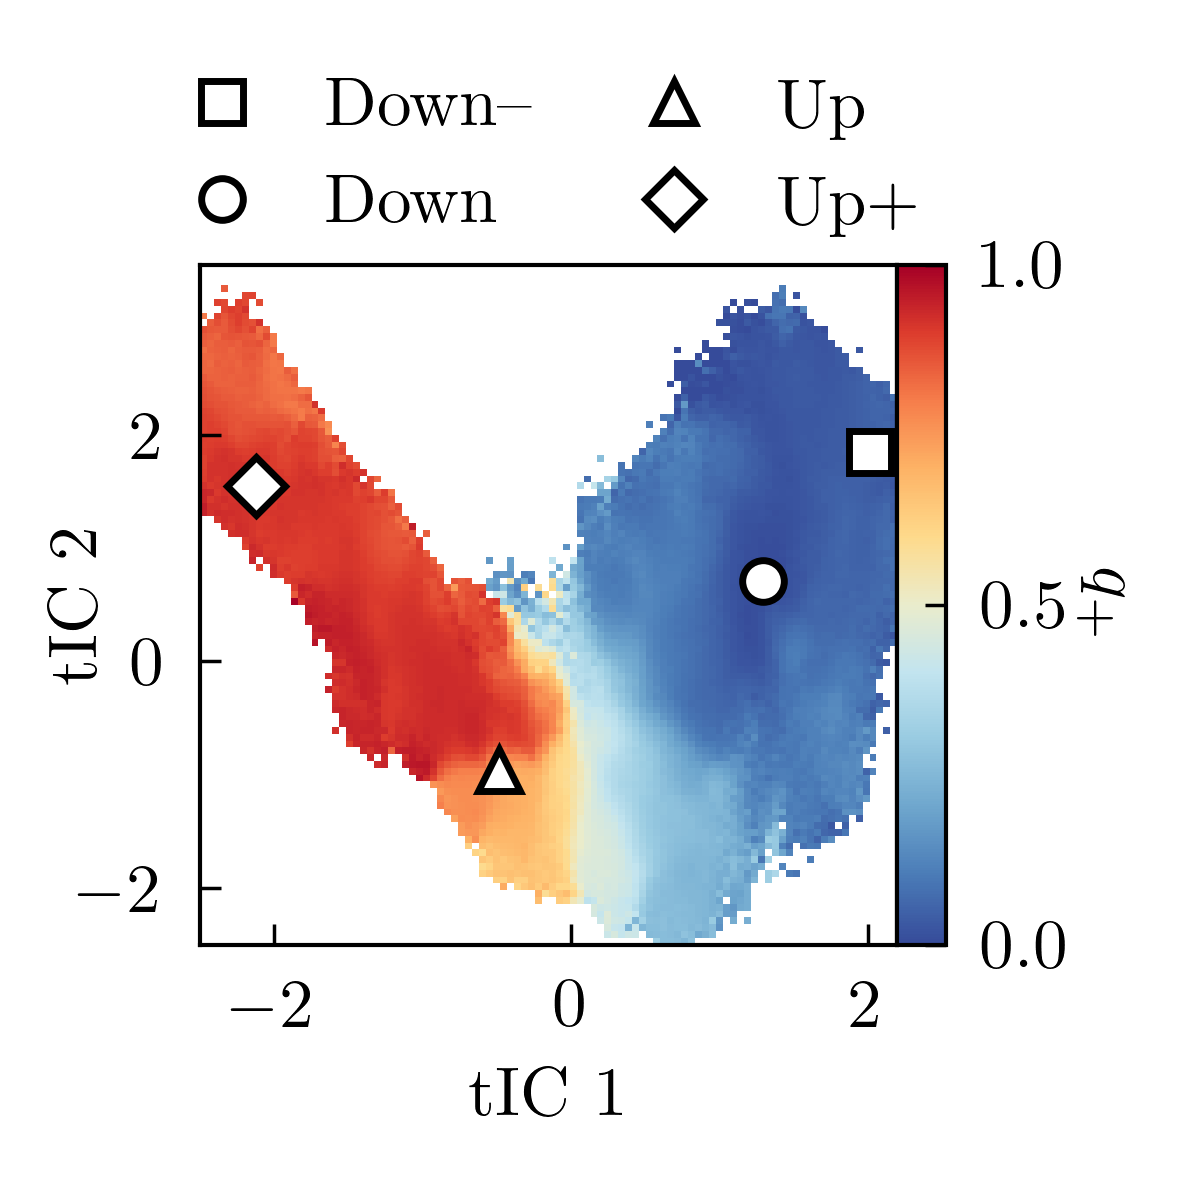

In [11]:
fig = plt.figure(figsize=(1.8, 1.8), dpi=500)
ax = plt.gca()

xe = np.linspace(-2.5, 2.2, 101)
ye = np.linspace(-2.5, 3.5, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2
vmin, vmax = 0, 1
levels = np.linspace(vmin, vmax, 51)
q_avg = extq.projection.average2d(tic1, tic2, qp_delay, w_delay, xe, ye)

plotting.plot_models(ax, ivac_models[:, 1:3], ms=6, zorder=5)
fig.legend(
    bbox_to_anchor=(0.5, 1.0),
    loc="center",
    ncol=2,
    labels=["Down–", "Down", "Up", "Up+"],
    columnspacing=1,
    handletextpad=0.5,
)

pc = plt.pcolormesh(xcent, ycent, q_avg.T, cmap="diverging", vmin=0, vmax=1, rasterized=True, shading='nearest')


plt.xlabel("tIC 1")
plt.ylabel("tIC 2", labelpad=-5)
cb = pplt.colorbar(pc)
cb.set_label("$q_+$", rotation=-90, labelpad=10)
cb.set_ticks(np.linspace(0, 1, 3))
plt.savefig("../../fig/paper/ivac_committor.pdf", bbox_inches='tight')